# Using PyQIR Parser
Most of the examples here of the visualization and interop come from this PR by @cgranade: https://github.com/microsoft/qsharp-compiler/pull/1221/

## How does the package work?

Just like any Python package, we need to import the package and then we want to load the QIR file we want to parse.

In [10]:
import pyqir_parser as pqp
mod = pqp.QirModule("teleportchain.baseprofile.bc")

In [11]:
dir(pqp)

['List',
 'Optional',
 'PyQirBasicBlock',
 'PyQirConstant',
 'PyQirFunction',
 'PyQirInstruction',
 'PyQirModule',
 'PyQirOperand',
 'PyQirParameter',
 'PyQirTerminator',
 'PyQirType',
 'QirAShrInstr',
 'QirAddInstr',
 'QirAndInstr',
 'QirArrayType',
 'QirBlock',
 'QirBrTerminator',
 'QirCallInstr',
 'QirCondBrTerminator',
 'QirConstant',
 'QirDoubleConstant',
 'QirDoubleType',
 'QirFAddInstr',
 'QirFCmpInstr',
 'QirFDivInstr',
 'QirFMulInstr',
 'QirFNegInstr',
 'QirFRemInstr',
 'QirFSubInstr',
 'QirFunction',
 'QirICmpInstr',
 'QirInstr',
 'QirIntConstant',
 'QirIntegerType',
 'QirLShrInstr',
 'QirLocalOperand',
 'QirModule',
 'QirMulInstr',
 'QirNamedStructType',
 'QirNullConstant',
 'QirOpInstr',
 'QirOperand',
 'QirOrInstr',
 'QirParameter',
 'QirPhiInstr',
 'QirPointerType',
 'QirQirCallInstr',
 'QirQisCallInstr',
 'QirQubitConstant',
 'QirQubitType',
 'QirResultConstant',
 'QirResultType',
 'QirRetTerminator',
 'QirRtCallInstr',
 'QirSDivInstr',
 'QirSRemInstr',
 'QirShlInstr',
 

We can then look at the attributes and functions that are a part of the `QirModule` class. Of particular interest are  
```
'functions',
'get_entrypoint_funcs',
'get_func_by_name',
'get_funcs_by_attr',
'get_interop_funcs'
```
as they are what allows us to drill into the module.

In [12]:
list(filter(lambda a: not(a.startswith('__')), dir(mod)))

['entrypoint_funcs',
 'functions',
 'get_func_by_name',
 'get_funcs_by_attr',
 'interop_funcs',
 'module']

We can then look at what functions are listed in the QIR program we imported.

In [13]:
[function.name for function in mod.functions]

['TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop']

We can either use an index on the mod.functions list or the `get_func_by_name` function.

In [14]:
func_name = "TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop"
func = mod.get_func_by_name(func_name)
print(func)

In [15]:
list(filter(lambda a:  not(a.startswith('__')), dir(func)))

['blocks',
 'func',
 'get_attribute_value',
 'get_block_by_name',
 'get_instruction_by_output_name',
 'name',
 'parameters',
 'required_qubits',
 'required_results',
 'return_type']

Now that we have a function, let's look at it's blocks.

In [16]:
list(filter(lambda a:  not(a.startswith('__')), dir(func.blocks[0])))

['block',
 'get_phi_pairs_by_source_name',
 'instructions',
 'name',
 'phi_nodes',
 'terminator']

In [17]:
[block.name for block in func.blocks]

['entry',
 'then0__1.i.i.i',
 'continue__1.i.i.i',
 'then0__2.i.i.i',
 'TeleportChain__TeleportQubitUsingPresharedEntanglement__body.2.exit.i',
 'then0__1.i.i1.i',
 'continue__1.i.i2.i',
 'then0__2.i.i3.i',
 'TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__body.1.exit']

To look at the function another way, let's use a visualization tool to see the relationship between the blocks.

In [26]:
import retworkx as rx
import retworkx.visualization
import matplotlib.pyplot as plt

def control_flow_graph(func : PyQirFunction) -> "rx.Digraph":
    cfg = rx.PyDiGraph(check_cycle=False, multigraph=True)
    blocks = func.blocks
    block_indices = {
        block.name: cfg.add_node(block)
        for block in blocks
    }

    idx_return = cfg.add_node("Return")
    idx_bottom = None

    for idx_block, block in enumerate(blocks):
        term = block.terminator
        if isinstance(term, pqp.QirCondBrTerminator):
            cfg.add_edge(idx_block, block_indices[term.true_dest], True)
            cfg.add_edge(idx_block, block_indices[term.false_dest], False)
        elif isinstance(term, pqp.QirBrTerminator):
            cfg.add_edge(idx_block, block_indices[term.dest], ())
        elif isinstance(term, pqp.QirRetTerminator):
            cfg.add_edge(idx_block, idx_return, ())
        elif isinstance(term, pqp.QirSwitchTerminator):
            print(f"Not yet implemented: {term} in {block}")
        elif isinstance(term, pqp.QirUnreachableTerminator):
            if idx_bottom is None:
                idx_bottom = cfg.add_node("⊥")
            cfg.add_edge(idx_block, idx_bottom)
        else:
            print(f"Not yet implemented: {term} in {block}")

    return cfg

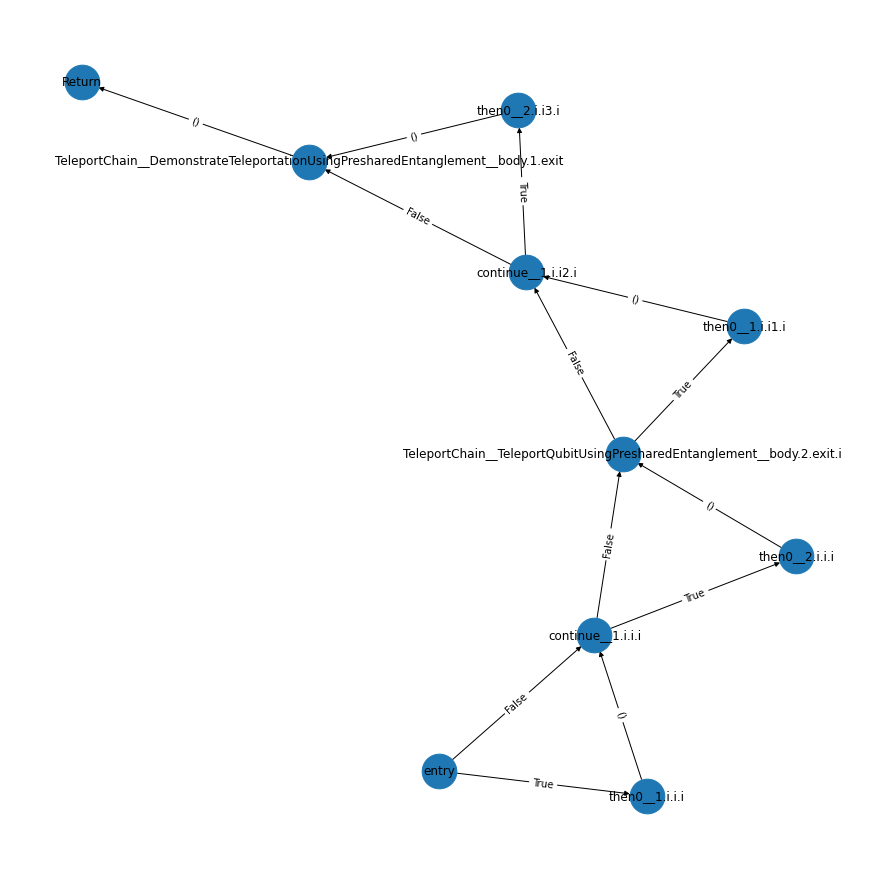

In [27]:
plt.figure(figsize=(12, 12))
rx.visualization.mpl_draw(
    control_flow_graph(mod.functions[0]),
    with_labels=True,
    labels=lambda block: getattr(block, "name", block),
    edge_labels=str,
    node_size=1200
)

Looking at all of the instructions in this function in the QIR program:

In [28]:
{block.name : [(inst.output_name, inst.type) for inst in block.instructions] for block in func.blocks}

{'entry': [(None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa940>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa670>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa790>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa6d0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa400>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa460>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa310>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa1c0>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa220>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7f4ac0>),
  ('0', <pyqir_parser.parser.QirIntegerType at 0x2da3c7f4b20>)],
 'then0__1.i.i.i': [(None,
   <pyqir_parser.parser.QirVoidType at 0x2da3c801b20>)],
 'continue__1.i.i.i': [(None,
   <pyqir_parser.parser.QirVoidType at 0x2da3c801100>),
  (None, <pyqir_parser.parser.QirVoidType at 0x2da3c7fa910>),
  ('1', <pyqir_parser.parser.QirIntegerType at 0x2da3c7faeb0>)],
 'then0__

## Testing export example
Want to import a bitcode file of a QIR program and dump it out to a cirq or qiskit object.

This is most simply viewed as an function on a block in a QIR function, so let's try this on the blocks from the QIR program loaded above. First we have to be sure that the block actually represents a circuit.

In [37]:
def is_circuit_like(block : QirBlock) -> bool:
    return all(
        isinstance(instruction, (QirQisCallInstr, QirQirCallInstr))
        for instruction in block.instructions
    )

In [39]:
blks = [block.name for block in func.blocks if is_circuit_like(block)]
print(blks)

['entry', 'then0__1.i.i.i', 'continue__1.i.i.i', 'then0__2.i.i.i', 'TeleportChain__TeleportQubitUsingPresharedEntanglement__body.2.exit.i', 'then0__1.i.i1.i', 'continue__1.i.i2.i', 'then0__2.i.i3.i']


### Open QASM2.0

In [ ]:
class OpenQasm20Exporter(block.name):
    header: List[str]
    lines: List[str]

    qubits: Dict[Any, Optional[int]]
    results: Dict[Any, Optional[int]]

    qreg = "q"
    creg = "c"

    def __init__(self, block_name: str):
        self.lines = []
        self.header = [
            f"// Generated from QIR block {block_name}.",
            "OPENQASM 2.0;",
            'include "qelib1.inc";',
            ""
        ]
        self.qubits = dict()
        self.results = dict()

    def qubit_as_expr(self, qubit) -> str:
        id_qubit = _resolve_id(qubit)
        if id_qubit not in self.qubits:
            self.qubits[id_qubit] = len(self.qubits)
        return f"{self.qreg}[{self.qubits[id_qubit]}]"

    def result_as_expr(self, result) -> str:
        id_result = _resolve_id(result)
        if id_result not in self.results:
            self.results[id_result] = len(self.results)
        return f"{self.creg}[{self.results[id_result]}]"

    def export(self) -> str:
        declarations = []
        if self.qubits:
            declarations.append(
                f"qreg {self.qreg}[{len(self.qubits)}];"
            )
        if self.results:
            declarations.append(
                f"creg {self.creg}[{len(self.results)}];"
            )

        return "\n".join(
            self.header + declarations + self.lines
        )

    def on_comment(self, text) -> None:
        # TODO: split text into lines first.
        self.lines.append(f"// {text}")

    def on_simple_gate(self, name, *qubits) -> None:
        qubit_args = [self.qubit_as_expr(qubit) for qubit in qubits]
        self.lines.append(f"{name} {', '.join(map(str, qubit_args))};")

    def on_measure(self, qubit, result) -> None:
        self.lines.append(f"measure {self.qubit_as_expr(qubit)} -> {self.result_as_expr(result)};")

In [ ]:
from types import MappingProxyType
from abc import ABCMeta, abstractmethod
from typing import Any, Callable, Dict, List, Optional, Set, Union, Generic, TypeVar
from .pyqir import *

try:
    import qiskit as qk
except ImportError:
    qk = None

try:
    import qutip as qt
    import qutip.qip.circuit
    import qutip.qip.operations
except ImportError:
    qt = None

TOutput = TypeVar('TOutput')

# TODO: Better names for these utility functions.
def _resolve_id(value: Any, default: str = "unsupported") -> Union[int, str]:
    if hasattr(value, "id"):
        return value.id
    return default

def _resolve(value, in_):
    id = _resolve_id(value)
    if id not in in_:
        in_[id] = len(in_)
    return in_[id]

class CircuitLikeExporter(Generic[TOutput], metaclass=ABCMeta):
    @abstractmethod
    def on_simple_gate(self, name, *qubits) -> None:
        pass

    @abstractmethod
    def on_measure(self, qubit, result) -> None:
        pass

    @abstractmethod
    def on_comment(self, text) -> None:
        pass

    @abstractmethod
    def export(self) -> TOutput:
        pass

    @abstractmethod
    def qubit_as_expr(self, qubit) -> str:
        pass

    @abstractmethod
    def result_as_expr(self, result) -> str:
        pass

In [ ]:
def export_to(block, exporter: CircuitLikeExporter[TOutput]) -> Optional[TOutput]:
    if not block.is_circuit_like:
        return None

    qis_gate_mappings = {
        '__quantum__qis__x__body': 'x',
        '__quantum__qis__y__body': 'y',
        '__quantum__qis__z__body': 'z',
        '__quantum__qis__h__body': 'h',
        '__quantum__qis__cnot__body': 'cnot'
    }

    for instruction in block.instructions:
        # Translate simple gates (that is, only quantum args).
        if instruction.func_name in qis_gate_mappings:
            exporter.on_simple_gate(qis_gate_mappings[instruction.func_name], *instruction.func_args)

        # Reset requires nonstandard support.
        elif instruction.func_name == "__quantum__qis__reset__body":
            exporter.on_comment("Requires nonstandard reset gate:")
            exporter.on_simple_gate("reset", *instruction.func_args)

        # Measurements are special in OpenQASM 2.0, so handle them here.
        elif instruction.func_name == "__quantum__qis__mz__body":
            target, result = instruction.func_args
            exporter.on_measure(target, result)
            # target = lookup_qubit(target)
            # result = lookup_result(result)
            # lines.append(f"measure {target} -> {result};")

        # Handle special cases of QIR functions as needed.
        elif instruction.func_name == "__quantum__qir__read_result":
            exporter.on_comment(f"%{instruction.output_name} = {exporter.result_as_expr(instruction.func_args[0])}")

        else:
            exporter.on_comment("// Unsupported QIS operation:")
            exporter.on_comment(f"// {instruction.func_name} {', '.join(map(str, instruction.func_args))}")

    return exporter.export()

In [ ]:
class QiskitExporter(CircuitLikeExporter["qk.QuantumCircuit"]):
    def __init__(self, block_name: str):
        self.oq2_exporter = OpenQasm20Exporter(block_name)
    def qubit_as_expr(self, qubit) -> str:
        return self.oq2_exporter.qubit_as_expr(qubit)
    def result_as_expr(self, result) -> str:
        return self.oq2_exporter.result_as_expr(result)
    def on_comment(self, text) -> None:
        return self.oq2_exporter.on_comment(text)
    def on_measure(self, qubit, result) -> None:
        return self.oq2_exporter.on_measure(qubit, result)
    def on_simple_gate(self, name, *qubits) -> None:
        return self.oq2_exporter.on_simple_gate(name, *qubits)
    def export(self) -> "qk.QuantumCircuit":
        return qk.QuantumCircuit.from_qasm_str(self.oq2_exporter.export())

### QuTiP

In [ ]:
class QuTiPExporter(CircuitLikeExporter["qt.qip.circuit.QubitCircuit"]):
    actions: List[Callable[["qt.qip.circuit.QubitCircuit"], None]]

    qubits: Dict[Any, int]
    results: Dict[Any, int]

    gate_names = MappingProxyType({
        'x': 'X',
        'y': 'Y',
        'z': 'Z',
        'reset': 'reset'
    })

    def __init__(self):
        self.actions = []
        self.qubits = {}
        self.results = {}

    def export(self) -> TOutput:
        circuit = qt.qip.circuit.QubitCircuit(N=len(self.qubits), num_cbits=len(self.results))
        for action in self.actions:
            action(circuit)
        return circuit

    def qubit_as_expr(self, qubit) -> str:
        return repr(_resolve(qubit, self.qubits))

    def result_as_expr(self, result) -> str:
        return repr(_resolve(result, self.results))

    def on_simple_gate(self, name, *qubits) -> None:
        targets = [_resolve(qubit, self.qubits) for qubit in qubits]
        self.actions.append(lambda circuit:
            circuit.add_gate(
                self.gate_names[name],
                targets=targets
            )
        )

    def on_measure(self, qubit, result) -> None:
        targets = [_resolve(qubit, self.qubits)]
        classical_store = _resolve(result, self.results)
        self.actions.append(lambda circuit:
            circuit.add_measurement(
                "MZ",
                targets=targets,
                classical_store=classical_store
            )
        )

    def on_comment(self, text) -> None:
        print(f"# {text}")

In [ ]:
class QirBlock:
    """
    Instances of the QirBlock type represent a basic block within a function body. Each basic block is
    comprised of a list of instructions executed in sequence and a single, special final instruction 
    called a terminator that indicates where execution should jump at the end of the block.
    """
    .
    .
    .
    @property
    def is_circuit_like(self) -> bool:
        return all(
            isinstance(instruction, (QirQisCallInstr, QirQirCallInstr))
            for instruction in self.instructions
        )
        # TODO: Check all args are qubit constants.

    def as_openqasm_20(self) -> Optional[str]:
        """
        If this block is circuit-like (that is, consists only of quantum instructions),
        converts it to a representation in OpenQASM 2.0; otherwise, returns `None`.
        Note that the returned representation does not include leading phi nodes, nor trailing terminators.
        """
        return export.export_to(self, export.OpenQasm20Exporter(self.name))

    def as_qiskit_circuit(self) -> Optional["qk.QuantumCircuit"]:
        return export.export_to(self, export.QiskitExporter(self.name))

    def as_qutip_circuit(self) -> Optional["qt.qip.circuit.QubitCircuit"]:
        return export.export_to(self, export.QuTiPExporter())

In [46]:
mod.functions[0].name

'TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop'

In [31]:
mod = module_from_bitcode("teleportchain.baseprofile.bc")
func_name = "TeleportChain__DemonstrateTeleportationUsingPresharedEntanglement__Interop"
blocks = mod.get_func_by_name(func_name).blocks
fav = mod.get_func_by_name(func_name).blocks[2]

In [33]:
[fav.instructions[i] for i in range(3)]

In [34]:
[blocks[i].terminator.is_br for i in range(len(blocks))]

[False, True, False, True, False, True, False, True, False]

In [35]:
blocks[1].terminator.br_dest

'continue__1.i.i.i'

In [36]:
#check if instructions in a block are circuit like i.e. are of the type `QirQisCallInstr` or `QirQirCallInstr`
[[isinstance(instruction, (QirQisCallInstr, QirQirCallInstr))
  for instruction in block.instructions]
  for block in mod.get_func_by_name(func_name).blocks]

[[False, False, False, False, False, False, False, False, False, False, False],
 [False],
 [False, False, False],
 [False],
 [False, False, False, False, False],
 [False],
 [False, False, False],
 [False],
 [False, False, False, False, False, False]]